# Spectrograms

In [1765]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

from mne.baseline import rescale
from mne.time_frequency import tfr_array_multitaper

from neurodsp.spectral import compute_spectrum
from neurodsp.sim import sim_powerlaw, sim_synaptic_current, sim_combined, sim_knee
from neurodsp.utils import create_times, set_random_seed

from fooof.plts import plot_spectra
from fooof.utils import trim_spectrum

from utils import save_fig

In [2]:
set_random_seed(505)

In [1480]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [32]:
# Simulation settings
n_seconds = 60
fs = 1000

exps = [-2, -1.0, 0.]

In [33]:
# Plot settings
#cmap = 'inferno'
cmap = 'viridis'

In [34]:
# Notebook settings
SAVE = False

## Simulate Data

In [35]:
# Simulate example powerlaw signals
white = sim_powerlaw(n_seconds, fs, 0)
pink = sim_powerlaw(n_seconds, fs, -1)

## Compute Spectrograms

Note - are multiple ways to create and plot spectrogram:
- compute with `spectrogram` from scipy, and then plot with `plt.imshow`
- use `plt.specgram` directly from matplotlib

In [37]:
# Compute spectrogram from scipy
f1, t1, pxx = spectrogram(pink, fs)

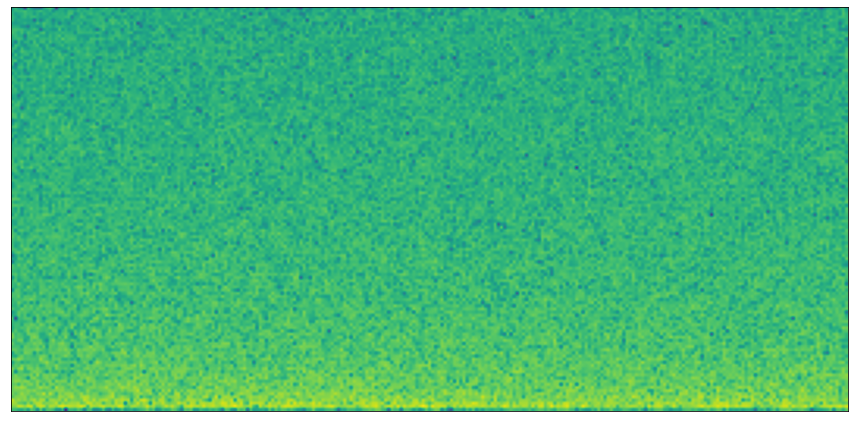

In [38]:
# Plot 
_, ax = plt.subplots(figsize=(15, 8.4))
ax.imshow(np.flipud(10*np.log10(pxx)), cmap=cmap, interpolation='hamming')
ax.set(xticks=[], yticks=[]);
save_fig(SAVE, 'scipy_spectrogram.pdf')

### Aperiodic Signal Periodograms

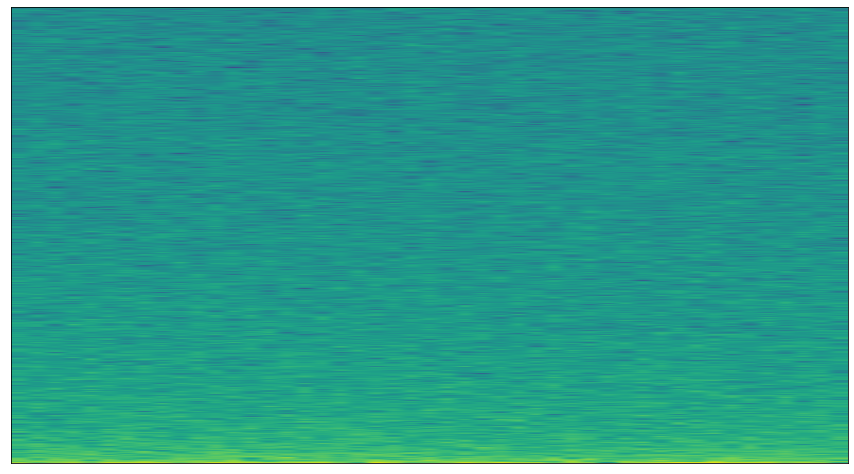

In [39]:
# Plot a spectrogram of pink noise
_, ax = plt.subplots(figsize=(15, 8.4))
pxx, freqs, bins, im = ax.specgram(pink, NFFT=int(2.25*fs), Fs=fs, noverlap=fs, cmap=cmap)
ax.set(xticks=[], yticks=[]);
save_fig(SAVE, 'pink_noise_spectrogram.pdf')

### Multi-Component Spectrogram

In [55]:
# Simulate a combined time series (multiple powerlaw components)
comb = np.array([])
for exp in exps:
    temp = sim_powerlaw(100, fs, exp)
    comb = np.concatenate((comb, temp))

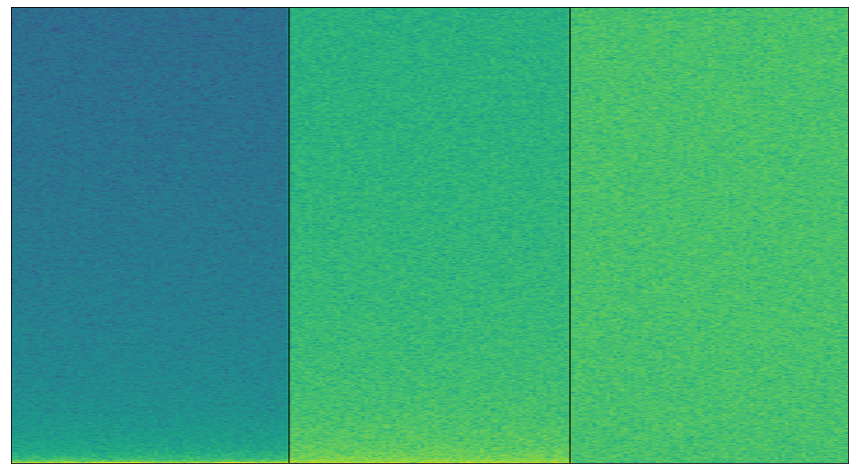

In [56]:
# Plot
_, ax = plt.subplots(figsize=(15, 8.4))
pxx, freqs, bins, im = ax.specgram(comb, NFFT=int(2.25*fs), Fs=fs, noverlap=fs, cmap=cmap)
ax.set(xticks=[], yticks=[]);
ax.axvline(x=100, color='black', alpha=0.75)
ax.axvline(x=200, color='black', alpha=0.75)
save_fig(SAVE, 'multi_noise_spectrogram_nl.pdf')

## Simulated Event Related 

In [1764]:
fs = 500
n_seconds = 2

In [1141]:
cmap = 'RdBu_r'

In [1702]:
components1 = comps = {'sim_knee' : {'chi1' : -0.25, 'chi2' : -2.5, 'knee' : 200}, 
                       'sim_bursty_oscillation' : [{'freq' : 23}, {'freq' : 24}, {'freq' : 24.5}, 
                                            {'freq' : 25}, {'freq' : 25.5,}, 
                                            {'freq' : 26,}, {'freq' : 27,}]
                      }
comp_vars = [1, 0.5, 0.5, 0.75, 1., 0.75, 0.5, 0.5]
sig1 = sim_combined(n_seconds, fs, components1, comp_vars)

In [1703]:
sig0s, sig1s, sig2s = [], [], []
sims = []
n_sims = 100
for ind in range(n_sims):
    sig0 = sim_knee(1, fs, -0.25, -2.5, 200)
    sig1 = sim_combined(n_seconds, fs, components1, comp_vars)
    sig2 = sim_knee(n_seconds, fs, -0.1, -1.7, 200)

    sig0s.append(sig0)
    sig1s.append(sig1)
    sig2s.append(sig2)
    
    comb = np.array([])
    for temp in [sig0, sig1, sig2]:
        comb = np.concatenate((comb, temp))
    sims.append(comb)
    
sims = np.array(sims)

In [1705]:
freqs = np.arange(1, 150, 0.25)
#freqs = np.logspace(np.log10(1), np.log10(150), 500)
n_cycles = freqs / 1.5

In [1706]:
out = tfr_array_multitaper(sims.reshape([1, *sims.shape]), fs, freqs=freqs,
                           n_cycles=n_cycles, output='power')
out = np.squeeze(out)

In [1707]:
# out = tfr_array_morlet(sims.reshape([1, *sims.shape]), fs, freqs=freqs,
#                        n_cycles=n_cycles, output='power')
# out = np.squeeze(out)

In [1708]:
times = create_times(n_seconds*2 + 1, fs)

In [1709]:
aa = rescale(out, times, [0.25, 0.75], 'ratio')

Applying baseline correction (mode: ratio)


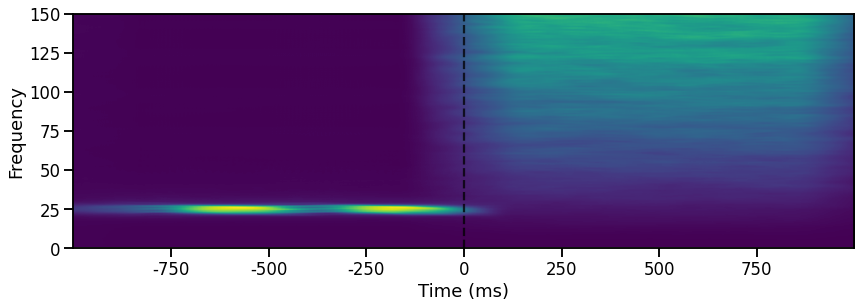

In [1762]:
_, ax = plt.subplots(figsize=(14, 10))
#ax.imshow(np.flipud(np.mean(out, 0)))
ax.imshow(np.flipud(np.mean(aa, 0)[:, 500:]))
ax.axvline(x=1000, color='black', alpha=0.75, linestyle='--')

ax.set_xticks([250, 500, 750, 1000, 1250, 1500, 1750],
              [-750, -500, -250, 0, 250, 500, 750]);

ax.set_yticks([0, 100, 200, 300, 400, 500, 600],
              ['150', '125', '100', '75', '50', '25', '0']);
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Frequency')
save_fig(True, 'spectrogram.pdf')

In [1715]:
psds1 = []
for sig in sig1s:
    freqs1, powers1 = trim_spectrum(*compute_spectrum(sig, fs, nperseg=1*fs), [1, 150])
    psds1.append(powers1)
    
psds2 = []
for sig in sig2s:
    freqs2, powers2 = trim_spectrum(*compute_spectrum(sig, fs, nperseg=1*fs), [1, 150])
    psds2.append(powers2)

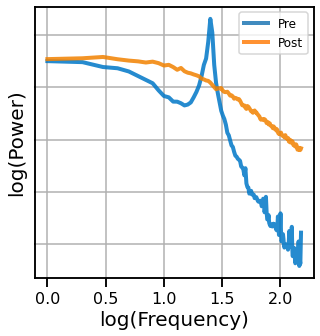

In [1760]:
_, ax = plt.subplots(figsize=(5, 5))
plot_spectra(freqs1, [np.mean(psds1, 0), np.mean(psds2, 0)], lw=4, alpha=0.85,
             log_freqs=True, log_powers=True, labels=['Pre', 'Post'], ax=ax)
plt.gca().yaxis.set_tick_params(length=1)
plt.gca().set_yticklabels([]);
plt.legend(loc=0, prop={'size': 12})
colors = ['#0077c7', '#f28100']
for line, color in zip(plt.gca().get_lines(), colors):
    line.set_color(color)
save_fig(True, 'spectrogram_psds.pdf')